**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 26 de setiembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter ( .IPYNB ) y todos los archivos adiconales que se requieran para correr su Cuaderno (En un archivo comprimido). En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569


# Trabajo Practico 1 - Andrey Arguedas Espinoza - 2020426569

## 0. Imports


In [1]:
import tensorflow as tf
import random
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, BatchNormalization

import seaborn as sns

## 1 - Load Data

### • We load initially the data from the CSV file

In [2]:
#Load data from CSV path
csv_path = 'C:/Users/AndreyArguedas/Desktop/DeepLearning/Documentos de Deep Learning GR 40/TP1/ham10000_metadata_2024-09-01.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9503 non-null   object 
 5   benign_malignant        9042 non-null   object 
 6   concomitant_biopsy      11720 non-null  bool   
 7   diagnosis               11720 non-null  object 
 8   diagnosis_confirm_type  11720 non-null  object 
 9   image_type              11719 non-null  object 
 10  lesion_id               11720 non-null  object 
 11  melanocytic             11720 non-null  bool   
 12  sex                     11377 non-null  object 
dtypes: bool(2), float64(1), object(10)
memory usage: 1.0+ MB


## • Now we build a dataset composed by the images and the corresponding label values (melanocytic = True/False)

### We also apply a resize of 50% on the images dimensions in order to reduce the memory consumption that we will have to do while building, splitting and handling the data

In [3]:
#Build dataset with images + corresponding label

data_path = 'C:/Users/AndreyArguedas/Desktop/DeepLearning/Documentos de Deep Learning GR 40/TP1/ISIC/'
#max_images = 200

def load_data(data_path, values_to_ignore, ignore_ratio):
    images = []
    labels = []
    n = 0
    
    for filename in os.listdir(data_path):

        melanocytic_value = df.loc[df['isic_id'] == filename.replace(".jpg", ""), 'melanocytic'].values[0]

        #if  melanocytic_value not in values_to_ignore or (random.randrange(0, ignore_ratio) != 0 and melanocytic_value in values_to_ignore):
        if  melanocytic_value not in values_to_ignore or melanocytic_value in values_to_ignore:
        
            # Open the image
            img_path = os.path.join(data_path, filename)
            # Resize the image to consume less resources and be able to load more data
            img = Image.open(img_path)
        
            # Calculate the new size
            new_size = (int(img.width * 0.5), int(img.height * 0.5))
    
            # Resize the image
            resized_img = img.resize(new_size, Image.LANCZOS)
        
            # Convert the image to a NumPy array for easier handling
            img_array = np.array(resized_img)

            # Add the new image arrary to list of data
            images.append(img_array)
            #We pair the label data with the image we are loading
            labels.append(df.loc[df['isic_id'] == filename.replace(".jpg", ""), 'melanocytic'].values[0])

            #if melanocytic_value == False and random.randrange(0, 2) == 0:
                #rotated_img = resized_img.rotate(90)
                #img_array = np.array(rotated_img)
                #images.append(img_array)
                #labels.append(False)
    
            n += 1
            if n % 1000 == 0:
                print("Number of images loaded:", n)  
            #if n == max_images:
            #break
    return (np.array(images) , np.array(labels))

images_data_array, labels = load_data(data_path, [True], 4)
# Check the shape of the resulting NumPy array
print(images_data_array.shape)
print(labels.shape)

Number of images loaded: 1000
Number of images loaded: 2000
Number of images loaded: 3000
Number of images loaded: 4000
Number of images loaded: 5000
Number of images loaded: 6000
Number of images loaded: 7000
Number of images loaded: 8000
Number of images loaded: 9000
Number of images loaded: 10000
Number of images loaded: 11000
(11720, 225, 300, 3)
(11720,)


In [4]:
dataset_images_trainX = images_data_array
dataset_images_trainY = labels

print("Size of images dataset: ", dataset_images_trainX.shape)
print("Size of labels: ", dataset_images_trainY.shape)

Size of images dataset:  (11720, 225, 300, 3)
Size of labels:  (11720,)


## 2 - Visualize the first 10 images to see they are loading correctly and with its corresponding Melanocytic value


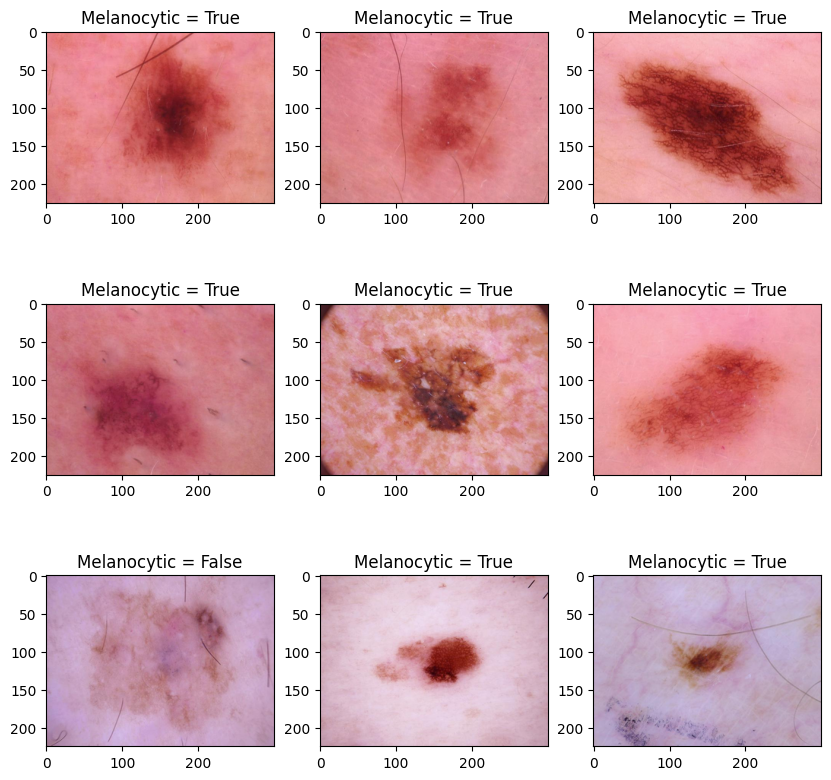

In [5]:
plt.figure(figsize=(10, 10))

for index, digit in zip(range(0, 9), dataset_images_trainX[:10]):
    plt.subplot(3, 3, index + 1)
    plt.imshow(digit)
    if dataset_images_trainY[index] == 1:
      plt.title("Melanocytic = True")
    else:
      plt.title("Melanocytic = False")
plt.show()

## 3 - We validate that we have the same proportion of True-False values from our loaded images


In [6]:
print("**********Melanocytic: values distribution from data loaded from CSV files**************\n")
print(df['melanocytic'].value_counts() , "\n")

print("**********Melanocytic: values distribution from builded dataset **************\n")
print("Count of positives for Melanocytic:" , len(list(filter(lambda i: i == 1, dataset_images_trainY))))
print("Count of false for Melanocytic:" , len(list(filter(lambda i: i == 0, dataset_images_trainY))))

**********Melanocytic: values distribution from data loaded from CSV files**************

melanocytic
True     9042
False    2678
Name: count, dtype: int64 

**********Melanocytic: values distribution from builded dataset **************

Count of positives for Melanocytic: 9042
Count of false for Melanocytic: 2678


## 4 - Data Preparation and splitting the dataset


## We split the data in a proportion of 60% training, 20% validation and 20% test

In [7]:
from sklearn.model_selection import train_test_split

# Step 1: Split into train (60%) and remaining (40%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset_images_trainX, dataset_images_trainY, train_size=0.6)


# Step 2: Split remaining data into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data labels: ", y_test.shape)


Dimensions of training data:  (7032, 225, 300, 3)
Dimensions of training labels:  (7032,)
Dimensions of validation data:  (2344, 225, 300, 3)
Dimensions of validation labels:  (2344,)
Dimensions of test data:  (2344, 225, 300, 3)
Dimensions of test data labels:  (2344,)


### Now we do data normalization and pixel value transformation across our splitting data 

In [8]:
d1, d2, d3, d4 = X_train.shape

X_train_prep = X_train.reshape((d1, d2*d3*d4))
X_train_prep = X_train_prep.astype('float32') / 255

d1, d2, d3, d4 = X_test.shape

X_test_prep = X_test.reshape((d1, d2*d3*d4))
X_test_prep = X_test_prep.astype('float32') / 255

d1, d2, d3, d4 = X_val.shape

X_val_prep = X_val.reshape((d1, d2*d3*d4))
X_val_prep = X_val_prep.astype('float32') / 255

print("Example of pixel transformation for an image", X_train_prep[0])


Example of pixel transformation for an image [0.9098039  0.6117647  0.7137255  ... 0.85490197 0.62352943 0.6901961 ]


## 5-  Define the Neural Network Architecture

In [9]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights", class_weight_dict)

Class weights {0: 2.162361623616236, 1: 0.6503884572697003}


In [10]:


network = models.Sequential()

network.add(layers.Dense(250, activation='relu', input_shape=(300*225*3,)))
# Add a dropout layer with a dropout rate of 0.3
#network.add(Dropout(0.3))
# Add batch normalization
network.add(BatchNormalization())
network.add(layers.Dense(85, activation='relu'))
# Add batch normalization
network.add(BatchNormalization())
#network.add(Dropout(0.3))
network.add(layers.Dense(20, activation='relu'))
#network.add(Dropout(0.3))
# Add batch normalization
network.add(BatchNormalization())
network.add(layers.Dense(1, activation='sigmoid'))

In [11]:
network.summary()

network.layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               50625250  
                                                                 
 batch_normalization (BatchN  (None, 250)              1000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 85)                21335     
                                                                 
 batch_normalization_1 (Batc  (None, 85)               340       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 20)                1720      
                                                                 
 batch_normalization_2 (Batc  (None, 20)               8

## 6 - Set the Neural Network configuration

In [12]:
network.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy', 'Precision'])

## 7 - Training phase

In [13]:
history = network.fit(X_train_prep,
                      y_train,
                      epochs=15,
                      #class_weight=class_weight_dict,
                      validation_data=(X_val_prep, y_val))

Epoch 1/15
220/220 [==============================] - 30s 129ms/step - loss: 0.5068 - accuracy: 0.7631 - precision: 0.8838 - val_loss: 0.4681 - val_accuracy: 0.7632 - val_precision: 0.8482
Epoch 2/15
220/220 [==============================] - 27s 123ms/step - loss: 0.3907 - accuracy: 0.8241 - precision: 0.8693 - val_loss: 0.4930 - val_accuracy: 0.7837 - val_precision: 0.7879
Epoch 3/15
220/220 [==============================] - 27s 124ms/step - loss: 0.3665 - accuracy: 0.8358 - precision: 0.8672 - val_loss: 0.7043 - val_accuracy: 0.7790 - val_precision: 0.7829
Epoch 4/15
220/220 [==============================] - 29s 131ms/step - loss: 0.3519 - accuracy: 0.8419 - precision: 0.8730 - val_loss: 0.4147 - val_accuracy: 0.8076 - val_precision: 0.8164
Epoch 5/15
220/220 [==============================] - 30s 134ms/step - loss: 0.3383 - accuracy: 0.8484 - precision: 0.8811 - val_loss: 0.4909 - val_accuracy: 0.7581 - val_precision: 0.9012
Epoch 6/15
220/220 [==============================] - 3

## 8 - Visualize metrics from the training phase

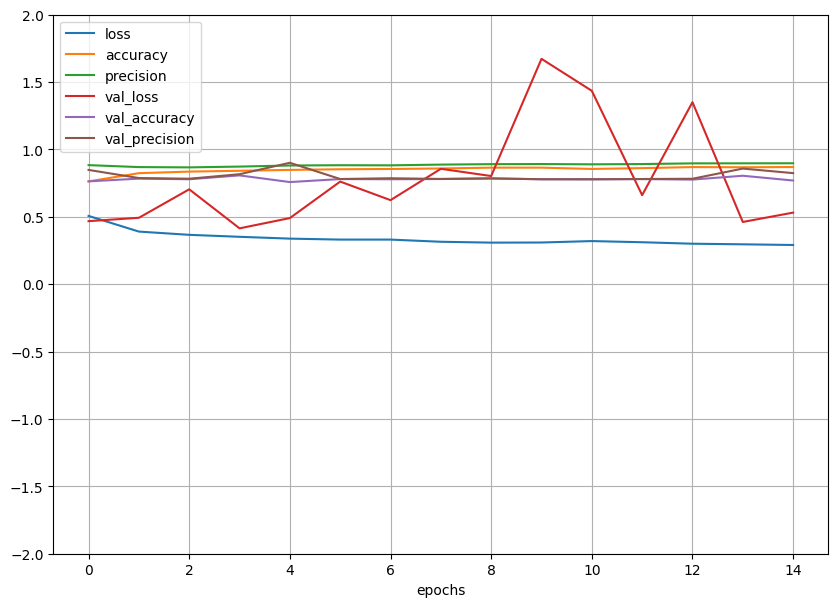

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(-2, 2)
plt.xlabel("epochs")
plt.show()

In [15]:
test_loss, test_acc, test_prec = network.evaluate(X_test_prep, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_prec)

74/74 [==============================] - 3s 38ms/step - loss: 0.5162 - accuracy: 0.7756 - precision: 0.8169
Test accuracy:  0.7755972743034363
Test Precision: 0.8168805241584778
Test Loss: 0.8168805241584778


## 9 - Prediction of new examples

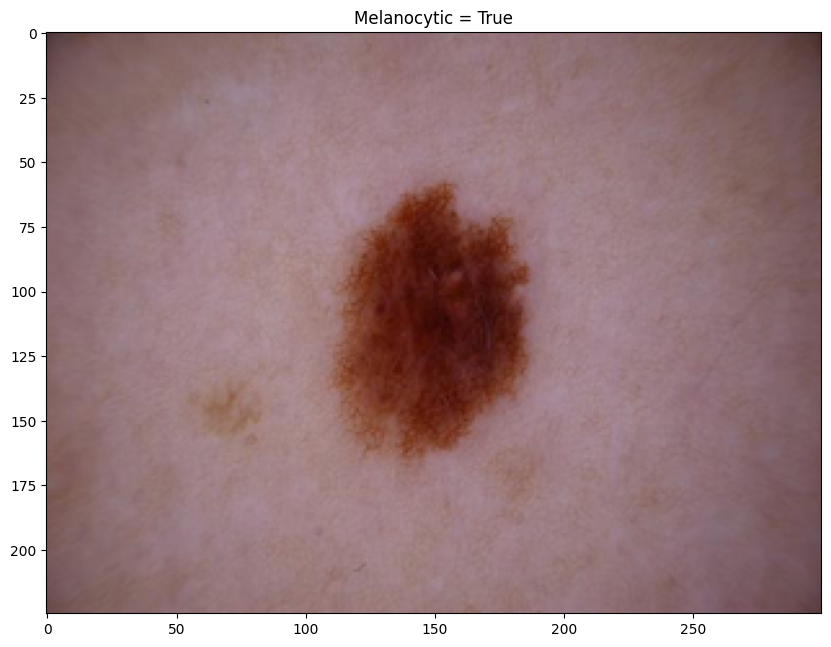

In [16]:
# Let's suppose X_new is a new image that has never been seen by our model
new_index = 0
X_new = X_test[new_index]

plt.figure(figsize=(10, 10))

plt.imshow(X_new)
if y_test[new_index] == 1:
  plt.title("Melanocytic = True")
else:
  plt.title("Melanocytic = False")

plt.show()



## • Every new image we need to normalize the data and transform the pixels

In [17]:
# Every new image we need to normalize the data and transform the pixels
d1, d2, d3 = X_new.shape

X_new_prep = X_new.reshape((1, d1*d2*d3))
X_new_prep = X_new_prep.astype('float32') / 255

### • Now we can predict the new image

In [18]:
# Do the prediction
y_pred = network.predict(X_new_prep)
print("Predicted: ", y_pred)
print("Actual value: ", y_test[new_index])


# Realizamos la prediccion obteniendo una clase en lugar de una probabilidad
print("Class predicted", np.round(y_pred)[0])

1/1 [==============================] - 0s 196ms/step
Predicted:  [[0.51709825]]
Actual value:  True
Class predicted [1.]


### • Now we check against the test set how many images predicted for each melanocytic value

In [19]:
predictions = network.predict(X_test_prep)
unique_originals, counts_originals = np.unique(y_test, return_counts=True)
print(f"Counts of originals test melanocytics = True: {counts_originals[1]}")
print(f"Counts of originals test melanocytics = False: {counts_originals[0]}")

unique_predictions, counts = np.unique(np.round(predictions), return_counts=True)
print(f"Unique predictions: {unique_predictions}")
print(f"Counts of predictions : {counts}")



74/74 [==============================] - 3s 34ms/step
Counts of originals test melanocytics = True: 1810
Counts of originals test melanocytics = False: 534
Unique predictions: [0. 1.]
Counts of predictions : [ 318 2026]


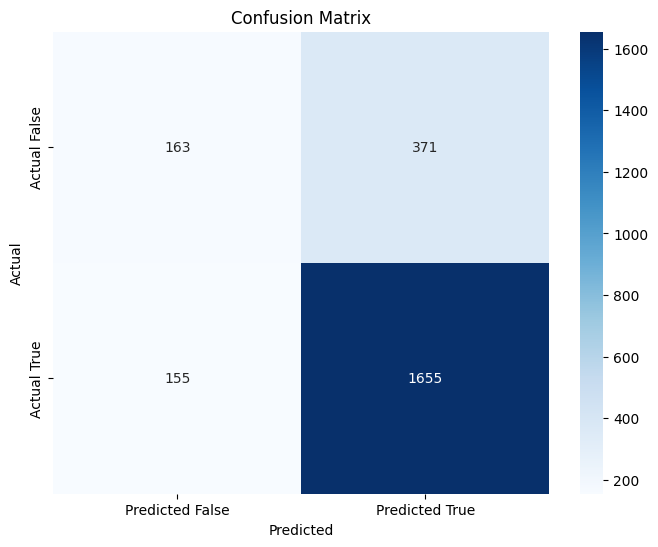

In [20]:
y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()